<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Multiclassification_2_layer_1D_CNN_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
# print(cicids2017_df.head().to_string())
# print(cicids2017_df.info())

# Print unique values and their counts for 'Attack Type'
print("\nAttack Type Distribution:")
print(cicids2017_df['Attack Type'].value_counts())

# --- Label Encoding ---

# Get unique attack types
attack_types = cicids2017_df['Attack Type'].unique()

# Create a mapping from attack type to integer label
attack_type_map = {type: i for i, type in enumerate(attack_types)}

# Apply label encoding
cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].map(attack_type_map)

print("\nLabel Encoding Mapping:")
print(attack_type_map)


Initial samples:
cicids2017_df shape: (2520751, 53)

Attack Type Distribution:
Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

Label Encoding Mapping:
{'Normal Traffic': 0, 'Port Scanning': 1, 'Web Attacks': 2, 'Brute Force': 3, 'DDoS': 4, 'Bots': 5, 'DoS': 6}


# Train/val/test split

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


Visualisation of data split

Input Shapes -> Train: (1613280, 52), Val: (403320, 52), Test: (504151, 52)
Labels distribution -> Train: [1340836   58044    1371    5856   81929    1247  123997], Val: [335209  14511    343   1464  20482    312  30999], Test: [419012  18139    429   1830  25603    389  38749]


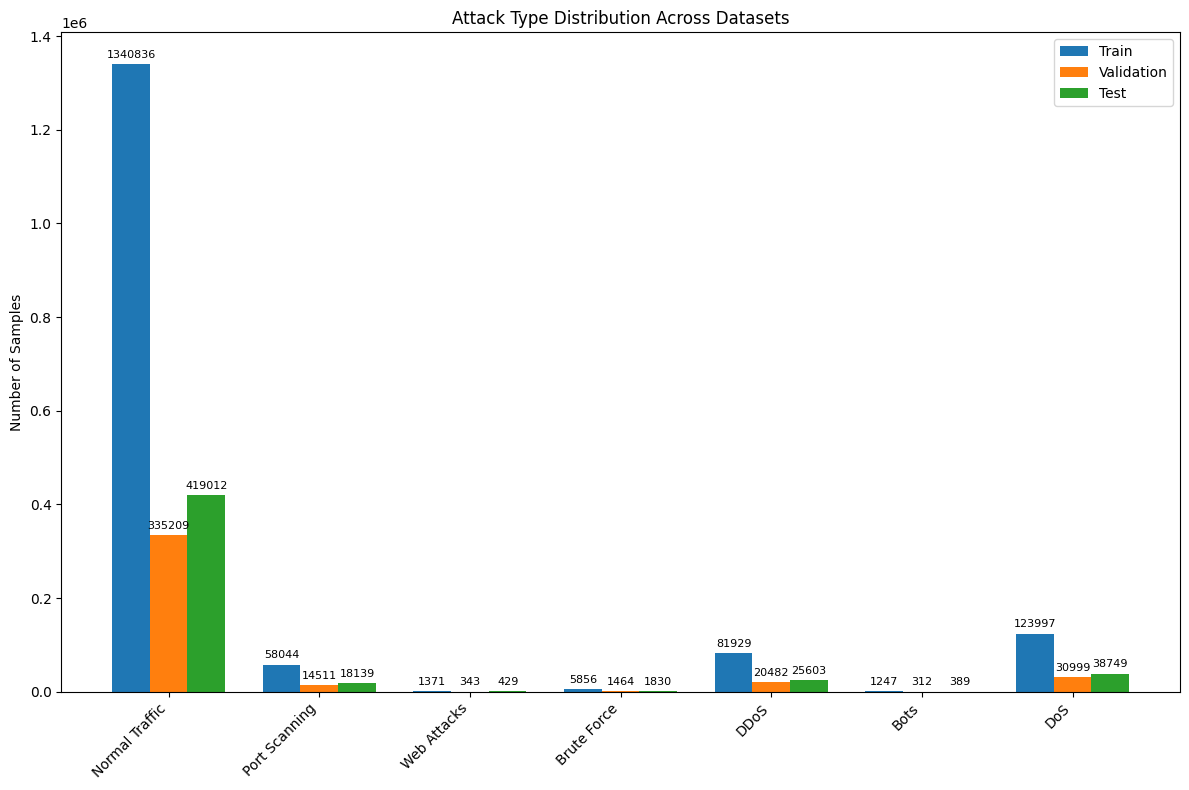

In [6]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Get the counts for each attack type in each dataset
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Get the number of unique attack types (based on the maximum index found)
num_attack_types = max(len(train_counts), len(val_counts), len(test_counts))

# Pad counts with zeros if some attack types are missing in a dataset split
train_counts = np.pad(train_counts, (0, num_attack_types - len(train_counts)), 'constant')
val_counts = np.pad(val_counts, (0, num_attack_types - len(val_counts)), 'constant')
test_counts = np.pad(test_counts, (0, num_attack_types - len(test_counts)), 'constant')


print(f"Labels distribution -> Train: {train_counts}, Val: {val_counts}, Test: {test_counts}")

# Data for plotting
datasets = ['Train', 'Validation', 'Test']
all_counts = np.array([train_counts, val_counts, test_counts])

# Get the original attack type names from the mapping
# Need to reverse the mapping to get names from labels
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(num_attack_types)]

x = np.arange(len(labels))  # the label locations for attack types
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8)) # Increase figure size

rects1 = ax.bar(x - width, all_counts[0], width, label='Train')
rects2 = ax.bar(x, all_counts[1], width, label='Validation')
rects3 = ax.bar(x + width, all_counts[2], width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Attack Type Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right") # Rotate labels for better readability
ax.legend()

# Add value labels (optional, can make the plot cluttered with many categories)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()

#Normalise the datasets

In [7]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
#scaler = RobustScaler() # Initialize the scaler
scaler = StandardScaler() # Initialize the scaler

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

Shape of X_train after scaling: (1613280, 52)
Shape of X_val after scaling: (403320, 52)
Shape of X_test after scaling: (504151, 52)


# SMOTE w/ training set

In [ ]:
# from imblearn.over_sampling import SMOTE # Import SMOTE
# from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
# import numpy as np

# # --- SMOTE ---
# smote = SMOTE(sampling_strategy={ 5: 2000,
#                                   2: 2000,
#                                   3: 7000,
#                                   1: 60000,
#                                   4: 85000,
#                                   6: 125000},
#                random_state=42) # Initialize a SMOTE object that oversamples the minority class (the malware classes) #sampling_strategy='not majority'


# # Apply SMOTE
# smote_X, smote_y = smote.fit_resample(X_train, y_train) #Generate synthetic malware samples using SMOTE

# # --- Attack Type Distribution ---
# new_distribution = smote_y.value_counts()
# print(f"Re-sampled training set:\n {new_distribution}")

# # --- Re-normalise resampled training set ---
# X_train = scaler.transform(smote_X)
# y_train = smote_y

Re-sampled training set:
 Attack Type
0    1340836
6     125000
4      85000
1      60000
3       7000
2       2000
5       2000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


# Data reshaping for 1D CNN input

In [8]:
import numpy as np

# Reshape the data for 1D CNN input
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1613280, 52, 1)
Validation input shape: (403320, 52, 1)
Test input shape: (504151, 52, 1)


# Perform Hyperparameter Tuning (Bayesian Optimisation) of 2 layer CNN model

In [ ]:
# Install tuner
!pip install keras-tuner --quiet

In [ ]:
# Setup
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [ ]:
def build_base_model(hp):
    model = Sequential()

    # First Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv1_filters', values=[8, 16, 32, 64, 128]),
        kernel_size=hp.Choice('conv1_kernel_size', values=[2, 3, 5]),
        activation='relu',
        input_shape=(52, 1) # Define input shape here
    ))

    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(hp.Choice('dropout1_rate', [0.0,0.2, 0.25, 0.3, 0.5])))

    # Second Conv1D block
    model.add(Conv1D(
        filters=hp.Choice('conv2_filters', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv2_kernel_size', values=[2, 3, 5]),
        activation='relu'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))

    # Flatten previous layers
    model.add(Flatten())

    # Dense layer with L2 regularization
    model.add(Dense(
        hp.Choice('dense_units', [8, 12, 24, 64]),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Choice('dense_L2', [0.0, 0.001, 0.0001, 0.01]))
    ))

    # Dropout layer
    model.add(Dropout(hp.Choice('dropout2_rate', [0.0, 0.2, 0.25, 0.3, 0.5])))

    # Dense layer for multiclass classification with softmax activation
    model.add(Dense(7, activation='softmax')) # Assuming 7 classes based on the value_counts output

    # Compile
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.005, 0.01])), #'adam', #add optimiser choices?
        loss='sparse_categorical_crossentropy', # Use sparse_categorical_crossentropy for integer labels
        metrics=['accuracy']
    )
    return model

In [ ]:
# --- Create tuner ---
tuner = kt.BayesianOptimization(
    build_base_model,
    objective= 'val_accuracy',#kt.Objective('val_f1_score', direction='max'),# Find the hyperparameters that give the highest possible F1 score on the validation set
    max_trials=10,
    directory='bayesian_tuning',
    project_name='baseline_cnn'
)

# --- Implement callback ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# --- Start tuning ---
tuner.search(X_train, y_train,
             epochs=10,
             batch_size=64,
             validation_data=(X_val, y_val),
             callbacks=[early_stop])

Reloading Tuner from bayesian_tuning/baseline_cnn/tuner0.json


In [ ]:
# --- Display Best Variables ---
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Best Hyperparameters:
conv1_filters: 8
conv1_kernel_size: 5
dropout1_rate: 0.0
conv2_filters: 128
conv2_kernel_size: 2
dense_units: 12
dense_L2: 0.001
dropout2_rate: 0.5
learning_rate: 0.001


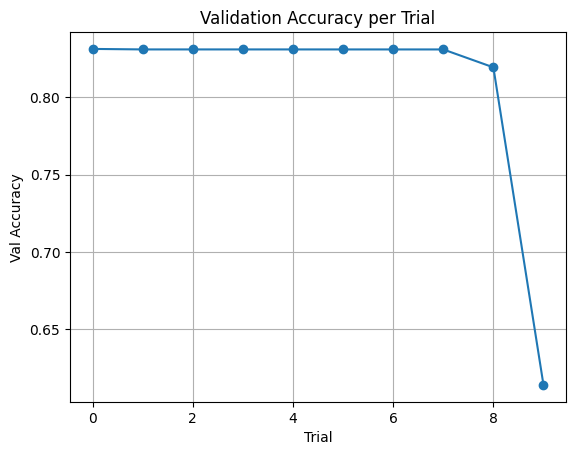

In [ ]:
# --- Visulise tunning results ---
import pandas as pd
import matplotlib.pyplot as plt

trials = tuner.oracle.get_best_trials(num_trials=20)
val_accuracies = [t.metrics.get_last_value('val_accuracy') for t in trials]

plt.plot(val_accuracies, marker='o')
plt.title('Validation Accuracy per Trial')
plt.xlabel('Trial')
plt.ylabel('Val Accuracy')
plt.grid(True)
plt.show()

#1D CNN model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define the 1D CNN Model
# Best Hyperparameters:
# conv1_filters: 32
# conv1_kernel_size: 2
# dropout1_rate: 0.0
# conv2_filters: 16
# conv2_kernel_size: 3
# dense_units: 64
# dense_L2: 0.0
# dropout2_rate: 0.5
# learning_rate: 0.005

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)
num_classes = len(attack_type_map) # Get the number of unique attack types for the output layer

# Build model
model = Sequential([
    Input(shape=input_shape),

    Conv1D(filters=32, kernel_size=2, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.0), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=16, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.5), # Randomly drop 50% of the network's neurons to further prevent overfitting
    Dense(num_classes, activation='softmax')  # Final output layer for multiclass classification
])

# Compile
model.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels #'adam'

#Summary
#model.summary()

#Train 1D CNN

- Major problems with class imbalance

Epoch 1/10
25342/25342 ━━━━━━━━━━━━━━━━━━━━ 104s 4ms/step - accuracy: 0.8403 - loss: 0.5230 - val_accuracy: 0.8051 - val_loss: 0.9443
Epoch 2/10
25342/25342 ━━━━━━━━━━━━━━━━━━━━ 133s 4ms/step - accuracy: 0.8483 - loss: 0.5058 - val_accuracy: 0.7445 - val_loss: 3.8569
Epoch 3/10
25342/25342 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.8611 - loss: 0.4722 - val_accuracy: 0.2955 - val_loss: 71.3620
Epoch 4/10
25342/25342 ━━━━━━━━━━━━━━━━━━━━ 93s 4ms/step - accuracy: 0.8775 - loss: 0.4046 - val_accuracy: 0.2686 - val_loss: 42.1758
Training time: 474.28 seconds


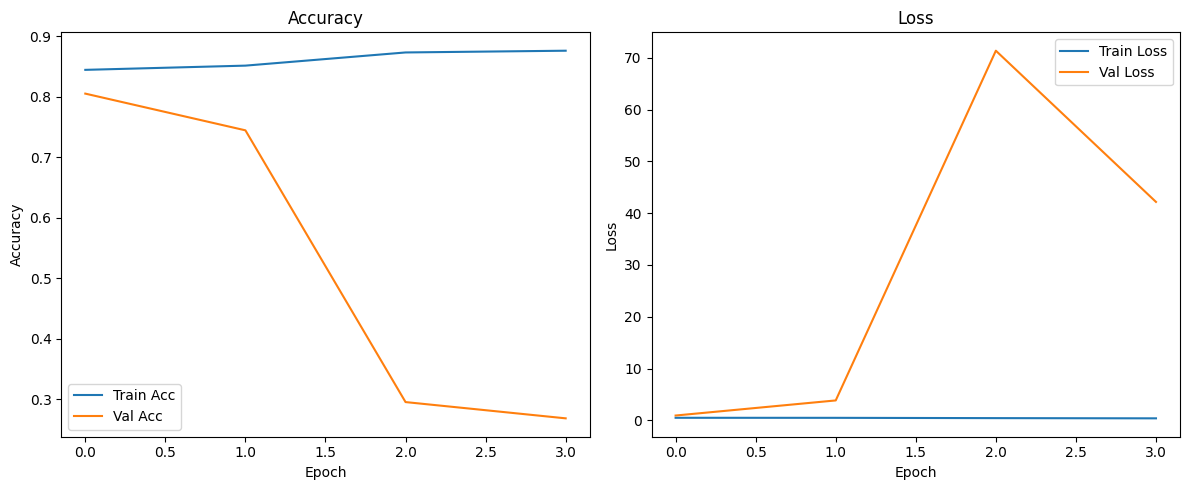

In [ ]:
import matplotlib.pyplot as plt
import timeit
from tensorflow.keras.callbacks import EarlyStopping

# --- Early-stopping --- #TESTING
# https://medium.com/@piyushkashyap045/early-stopping-in-deep-learning-a-simple-guide-to-prevent-overfitting-1073f56b493e
# Early-stopping is a regularisation technique that prevents overfitting by stopping the training process when the model’s performance on the validation dataset starts degrading
# Stopping early reduces training time and computational costs

early_stopping = EarlyStopping(monitor='val_loss', # Specify monitor='val_loss' to track the validation loss.
                               patience=3, #the number of epochs to wait for an improvement
                               restore_best_weights=True) # Revert the model to its state where it outputted the lowest validation loss

# Train the model with early stopping
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")


# Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



#K-fold Cross Validation
https://media.datacamp.com/legacy/v1718738336/image_0bb32b40f1.jpg


Stratified K-fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
accuracy_scores = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")

    # Split data
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]


    #Normalise
    x_train_fold = scaler.fit_transform(x_train_fold)
    x_test_fold = scaler.transform(x_test_fold)

    #Shape for CNN Input
    x_train_fold = x_train_fold.reshape((x_train_fold.shape[0], x_train_fold.shape[1], 1))
    x_test_fold = x_test_fold.reshape((x_test_fold.shape[0], x_test_fold.shape[1], 1))

    # Define model inside loop
    model = Sequential([
        Input(shape=(x_train_fold.shape[1], 1)),
        Conv1D(filters=32, kernel_size=2, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.0),
        Conv1D(filters=16, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0)),
        Dropout(0.5),
        Dense(len(attack_type_map), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train
    history = model.fit(
        x_train_fold, y_train_fold,
        epochs=10,
        batch_size=64,
        validation_data=(x_test_fold, y_test_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate
    loss, acc = model.evaluate(x_test_fold, y_test_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    accuracy_scores.append(acc)

# Final results
print('\nList of accuracy scores:', accuracy_scores)
print('Maximum Accuracy: {:.2f}%'.format(max(accuracy_scores) * 100))
print('Minimum Accuracy: {:.2f}%'.format(min(accuracy_scores) * 100))
print('Mean Accuracy: {:.2f}%'.format(mean(accuracy_scores) * 100))
print('Standard Deviation: {:.4f}'.format(stdev(accuracy_scores)))


--- Fold 1 ---


# Evaluate 1D CNN Malware Detection Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns # Import seaborn for heatmap plotting
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Get models predictions of x_test dataset
y_pred_probs = model.predict(X_test)

# For multiclass classification, the prediction is the class with the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Confusion matrix ---
# For multiclass, confusion_matrix directly handles the true and predicted labels
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix:")

# --- Heatmap ---
# Get the original attack type names from the mapping
reverse_attack_type_map = {v: k for k, v in attack_type_map.items()}
labels = [reverse_attack_type_map.get(i, f'Unknown {i}') for i in range(cm.shape[0])] # Use matrix shape for label count

# Plot heatmap
plt.figure(figsize=(8, 6)) # Adjust figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Accuracy scores
print("\nAccuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
# target_names should be the actual class names
report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
print(classification_report(y_test, y_pred, target_names=labels))

# --- Custom Metrics for Malware vs Benign (Normal Traffic) ---
normal_traffic_label = attack_type_map.get('Normal Traffic', None)

if normal_traffic_label is not None:
    # True Positives for Malware = sum of diagonals excluding 'Normal Traffic'
    malware_identified_count = np.sum(np.diag(cm)) - cm[normal_traffic_label, normal_traffic_label]

    # Total Malware = sum of all non-'Normal Traffic' samples
    total_malware_count = np.sum(cm) - np.sum(cm[normal_traffic_label, :])

    # % of Malware Identified
    percentage_malware_identified = (malware_identified_count / total_malware_count) * 100 if total_malware_count > 0 else 0

    # False Positives = Non-'Normal' samples predicted as 'Normal'
    benign_not_identified_count = np.sum(cm[normal_traffic_label, :]) - cm[normal_traffic_label, normal_traffic_label]
    total_benign_count = np.sum(cm[normal_traffic_label, :])

    # % of Benign Traffic Misclassified
    percentage_benign_not_identified = (benign_not_identified_count / total_benign_count) * 100 if total_benign_count > 0 else 0

    print(f"Total Malware Samples: {total_malware_count}")
    print(f"Malware Identified (True Positives): {malware_identified_count}")
    print(f"Percentage of Malware Identified: {percentage_malware_identified:.2f}%")
    print(f"Total Benign Samples: {total_benign_count}")
    print(f"Benign Misclassified as Malware (False Positives): {benign_not_identified_count}")
    print(f"Percentage of Benign Misclassified: {percentage_benign_not_identified:.2f}%")

    # --- Calculate and print TP, TN, FP, FN for Malware vs Benign ---
    # For binary classification (Malware vs Benign):
    # TP: Malware correctly predicted as Malware (malware_identified_count)
    # TN: Benign correctly predicted as Benign (cm[normal_traffic_label, normal_traffic_label])
    # FP: Benign incorrectly predicted as Malware (benign_not_identified_count)
    # FN: Malware incorrectly predicted as Benign (Total Malware Samples - Malware Identified)

    tp = malware_identified_count
    tn = cm[normal_traffic_label, normal_traffic_label]
    fp = benign_not_identified_count
    fn = total_malware_count - malware_identified_count

    print("\nTP, TN, FP, FN for Malware vs Benign:")
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")